# Phân cụm khách hàng từ giao dịch với Agglomerative Clustering

Mục tiêu:
- Tạo đặc trưng RFM (Recency, Frequency, Monetary) và vài đặc trưng giao dịch cơ bản (AOV, Basket Size)
- Chuẩn hoá dữ liệu
- Phân cụm khách hàng bằng **Agglomerative Clustering (Hierarchical)**
- Trực quan hoá hồ sơ cụm, các yếu tố ảnh hưởng và rút ra kết luận

Lưu ý hiệu năng: bảng giao dịch trong SQL Server có kích thước lớn, sẽ được xử lý theo từng "chunk" để tiết kiệm RAM.

Notebook này tách riêng khỏi file `CustomerClustering.ipynb` (KMeans) để bạn dễ so sánh giữa các thuật toán gom cụm.


In [1]:
import os
import math
import gc
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pyodbc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score

sns.set_theme(style='whitegrid')


In [2]:
# Kết nối SQL Server
conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=DAIHAITRAN;"
    "DATABASE=GFRS_DW;"
    "Trusted_Connection=yes;"
)

CHUNK_SIZE = 500_000  # điều chỉnh nếu RAM hạn chế
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"Sử dụng chunksize={CHUNK_SIZE} khi đọc Fact_TRANSACTIONS từ SQL Server")


Sử dụng chunksize=500000 khi đọc Fact_TRANSACTIONS từ SQL Server


In [3]:
# Câu lệnh truy vấn giống notebook KMeans
query1 = "select T.*, FullDate from [dbo].[Fact_TRANSACTIONS] T ,[dbo].[Dim_DATE] D where T.DateID = D.DateID"
query2 = "SELECT * FROM [dbo].[Dim_CUSTOMER]"
query3 = "SELECT * FROM [dbo].[Dim_PRODUCTS]"

print("Đã khai báo query giao dịch, khách hàng, sản phẩm")


Đã khai báo query giao dịch, khách hàng, sản phẩm


In [4]:
# Hàm nhận diện cột theo tên gần đúng (tái sử dụng logic từ notebook KMeans)

def detect_columns(df: pd.DataFrame):
    cols = {c: c for c in df.columns}
    low = {c.lower().strip(): c for c in df.columns}

    def pick(cands):
        for k in cands:
            if k in low:
                return low[k]
        for k in low:
            for cand in cands:
                if cand in k:
                    return low[k]
        return None

    customer_col = pick([
        'customer id','customer_id','customerid','cust id','client id','client_id','user id','user_id'
    ])
    date_col = pick([
        'date','datetime','transaction date','invoice date','order date','purchase date','timestamp'
    ])
    qty_col = pick(['quantity','qty','units'])
    price_col = pick(['price','unit price','unit_price','list price','sale price','selling price'])
    total_col = pick(['total','amount','revenue','sales','gross','net'])
    discount_pct_col = pick(['discount pct','discount_pct','discount%','pct discount','rate discount'])
    discount_amt_col = pick(['discount amount','discount_amt','discount value'])
    product_col = pick(['product id','product_id','sku','item id','item_id'])
    store_col = pick(['store id','store_id','shop id'])

    return {
        'customer': customer_col,
        'date': date_col,
        'quantity': qty_col,
        'unit_price': price_col,
        'total': total_col,
        'discount_pct': discount_pct_col,
        'discount_amt': discount_amt_col,
        'product': product_col,
        'store': store_col,
    }

# Thử đọc vài dòng để nhận diện cột
sample = pd.read_sql_query(query1, conn)
colmap = detect_columns(sample)

# Ép dùng cột ngày đúng là 'FullDate'
if 'FullDate' in sample.columns:
    colmap['date'] = 'FullDate'

colmap


{'customer': 'CustomerID',
 'date': 'FullDate',
 'quantity': 'Quantity',
 'unit_price': 'UnitPrice',
 'total': 'LineTotal',
 'discount_pct': None,
 'discount_amt': None,
 'product': None,
 'store': None}

In [5]:
# Nạp bản đồ sản phẩm -> ProductID -> (Category, SubCategory)
products = pd.read_sql_query(query3, conn)

# Chuẩn hoá tên cột để bắt đúng
prod_id_col = None
for c in products.columns:
    if c.lower().strip() in ['product id','product_id','sku','item id','item_id']:
        prod_id_col = c
        break
    if 'product' in c.lower():
        prod_id_col = c

cat_col = None
subcat_col = None
for c in products.columns:
    cl = c.lower().strip()
    if cl in ['category'] or 'category' in cl:
        if cat_col is None:
            cat_col = c
        elif subcat_col is None and c != cat_col:
            subcat_col = c

prod_map = None
if prod_id_col is not None:
    keep_cols = [prod_id_col]
    if cat_col is not None:
        keep_cols.append(cat_col)
    if subcat_col is not None:
        keep_cols.append(subcat_col)

    products_small = products[keep_cols].copy()
    products_small.columns = ['ProductID', 'Category', 'SubCategory'][:len(keep_cols)]
    products_small = products_small.drop_duplicates(subset=['ProductID'])
    prod_map = products_small.set_index('ProductID').to_dict(orient='index')

len(products), (list(products.columns)[:6] if products is not None else [])


(64136,
 ['ProductID',
  'ProductHash',
  'CategoryID',
  'ColorID',
  'SubCategoryID',
  'SizeID'])

In [6]:
# Hàm tính tiền thuần từ 1 chunk (giống notebook KMeans)

def compute_net_amount(df, colmap):
    qty = df[colmap['quantity']] if colmap['quantity'] in df.columns else 1
    net = None
    if colmap['total'] in df.columns:
        net = df[colmap['total']].astype(float)
    else:
        unit = None
        if colmap['unit_price'] in df.columns:
            unit = df[colmap['unit_price']].astype(float)
        elif 'price' in [c.lower() for c in df.columns]:
            for c in df.columns:
                if 'price' in c.lower():
                    unit = df[c].astype(float)
                    break
        if unit is not None:
            net = unit * qty
    if net is None:
        net = pd.Series(0.0, index=df.index)
    if colmap['discount_pct'] in df.columns:
        pct = pd.to_numeric(df[colmap['discount_pct']], errors='coerce').fillna(0).clip(lower=0, upper=1)
        net = net * (1 - pct)
    if colmap['discount_amt'] in df.columns:
        amt = pd.to_numeric(df[colmap['discount_amt']], errors='coerce').fillna(0)
        net = (net - amt).clip(lower=0)
    return net

from collections import defaultdict

agg = {
    'last_date': defaultdict(lambda: pd.Timestamp.min),
    'freq': defaultdict(int),
    'monetary': defaultdict(float),
    'quantity': defaultdict(float),
}

cat_counts = defaultdict(lambda: defaultdict(int))
subcat_counts = defaultdict(lambda: defaultdict(int))

# Dò type ngày để parse
date_parser = None
if colmap['date'] is not None:
    date_parser = [colmap['date']]

reader = pd.read_sql_query(
    query1,
    conn,
    chunksize=CHUNK_SIZE,
    parse_dates=date_parser if date_parser else None,
)

cust_col = colmap['customer']
prod_col = colmap['product']
qty_col = colmap['quantity']

for i, chunk in enumerate(reader, start=1):
    if cust_col is None or cust_col not in chunk.columns:
        raise ValueError('Không tìm thấy cột Customer ID trong transactions.')
    if colmap['date'] and colmap['date'] in chunk.columns and not np.issubdtype(chunk[colmap['date']].dtype, np.datetime64):
        chunk[colmap['date']] = pd.to_datetime(chunk[colmap['date']], errors='coerce')

    net = compute_net_amount(chunk, colmap)
    q = pd.to_numeric(chunk[qty_col], errors='coerce').fillna(0) if qty_col in chunk.columns else pd.Series(1, index=chunk.index)

    cust = chunk[cust_col]

    if colmap['date'] and colmap['date'] in chunk.columns:
        dt = chunk[colmap['date']]
        for cid, d in zip(cust, dt):
            if pd.notnull(d) and d > agg['last_date'][cid]:
                agg['last_date'][cid] = d

    for cid, n, qq in zip(cust, net, q):
        agg['freq'][cid] += 1
        agg['monetary'][cid] += float(n) if pd.notnull(n) else 0.0
        agg['quantity'][cid] += float(qq) if pd.notnull(qq) else 0.0

    if prod_map is not None and prod_col in chunk.columns:
        for cid, pid in zip(cust, chunk[prod_col]):
            info = prod_map.get(pid)
            if info:
                cat = info.get('Category')
                subc = info.get('SubCategory')
                if cat:
                    cat_counts[cid][cat] += 1
                if subc:
                    subcat_counts[cid][subc] += 1

    if i % 5 == 0:
        print(f"Đã xử lý {i} chunks")

print("Hoàn tất gom giao dịch")

rfm = pd.DataFrame({
    'CustomerID': list(agg['freq'].keys()),
})
rfm['Frequency'] = rfm['CustomerID'].map(agg['freq'])
rfm['Monetary'] = rfm['CustomerID'].map(agg['monetary'])
rfm['Quantity'] = rfm['CustomerID'].map(agg['quantity'])
rfm['LastDate'] = rfm['CustomerID'].map(agg['last_date'])

if 'LastDate' in rfm.columns:
    rfm['LastDate'] = pd.to_datetime(rfm['LastDate'], errors='coerce')
    if rfm['LastDate'].notna().any():
        max_date = rfm['LastDate'].max()
        rfm['Recency'] = (max_date - rfm['LastDate']).dt.days.astype('float')
    else:
        print("[Cảnh báo] Không có giá trị ngày hợp lệ trong LastDate, Recency sẽ = NaN")
        rfm['Recency'] = np.nan
else:
    print("[Cảnh báo] Không tìm thấy cột LastDate trong rfm, Recency sẽ = NaN")
    rfm['Recency'] = np.nan

rfm['AOV'] = (rfm['Monetary'] / rfm['Frequency']).replace([np.inf, -np.inf], np.nan).fillna(0)
rfm['AvgBasketSize'] = (rfm['Quantity'] / rfm['Frequency']).replace([np.inf, -np.inf], np.nan).fillna(0)

rfm.head(), rfm.describe(include='all').T.head(10)


Đã xử lý 5 chunks
Đã xử lý 10 chunks
Hoàn tất gom giao dịch


(   CustomerID  Frequency  Monetary  Quantity   LastDate  Recency        AOV  \
 0     1365497         10     429.0      10.0 2025-02-01     45.0  42.900000   
 1     1415711         13     313.0      13.0 2024-12-27     81.0  24.076923   
 2     1400833         10     186.0      10.0 2024-05-06    316.0  18.600000   
 3     1361988          3      63.0       3.0 2024-12-29     79.0  21.000000   
 4     1320939         37    1217.0      40.0 2025-02-05     41.0  32.891892   
 
    AvgBasketSize  
 0       1.000000  
 1       1.000000  
 2       1.000000  
 3       1.000000  
 4       1.081081  ,
                    count                           mean                  min  \
 CustomerID     1283707.0                  822032.367425                  1.0   
 Frequency      1283707.0                       4.998669                  1.0   
 Monetary       1283707.0                     570.792746             -10668.0   
 Quantity       1283707.0                       5.499753                 

In [16]:
# Sắp xếp theo CustomerID và xem nhanh
rfm = rfm.sort_values(by='CustomerID')
rfm.head()


,CustomerID,Frequency,Monetary,Quantity,LastDate,Recency,AOV,AvgBasketSize,Cluster_HC
362493,1,3,816.0,3.0,2024-03-17,366.0,272.000000,1.000000,2
348361,2,2,451.0,2.0,2023-11-27,477.0,225.500000,1.000000,2
311914,3,13,5621.0,15.0,2025-01-29,48.0,432.384615,1.153846,2
325586,4,13,5474.0,15.0,2025-01-09,68.0,421.076923,1.153846,2
347082,5,10,3094.0,10.0,2025-03-08,10.0,309.400000,1.000000,2


In [8]:
# Chuẩn bị dữ liệu cho phân cụm (giống logic notebook KMeans)
base_features = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']
use_features = base_features

X = rfm[use_features].copy()

# Làm sạch giá trị bất thường/inf/NaN và cắt đuôi phân phối
if 'Monetary' in X.columns and X['Monetary'].notna().any():
    m_cap = X['Monetary'].quantile(0.999)
    if pd.notna(m_cap):
        X['Monetary'] = np.clip(X['Monetary'], 0, m_cap)
X['Monetary'] = np.log1p(X['Monetary'].clip(lower=0))

if 'Recency' in X.columns and X['Recency'].notna().any():
    r_cap = X['Recency'].quantile(0.999)
    if pd.notna(r_cap):
        X['Recency'] = np.clip(X['Recency'], 0, r_cap)
X['Recency'] = np.sqrt(np.clip(X['Recency'], a_min=0, a_max=None))

for col in [c for c in ['Frequency','AOV','AvgBasketSize'] if c in X.columns]:
    if X[col].notna().any():
        cap = X[col].quantile(0.999)
        if pd.notna(cap):
            X[col] = np.clip(X[col], 0, cap)

X = X.replace([np.inf, -np.inf], np.nan)
for col in X.columns:
    med = X[col].median(skipna=True)
    if pd.isna(med):
        med = 0.0
    X[col] = X[col].fillna(med)

X = X.astype('float64')

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X.shape, X_scaled[:3]


((1283707, 5),
 array([[ 0.76007429, -0.2       ,  0.80632957,  4.15396341,  0.        ],
        [ 1.04219582, -0.4       ,  0.47672668,  3.30335366,  0.        ],
        [-0.51067106,  1.8       ,  1.88029164,  7.08782833,  2.76923077]]))

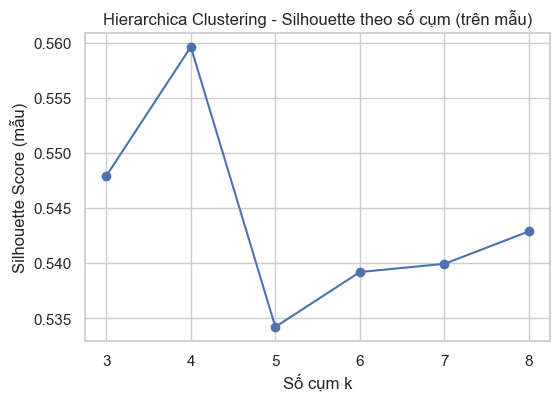

[(3, np.float64(0.5479137688087808)),
 (4, np.float64(0.559613532541766)),
 (5, np.float64(0.534238629287692)),
 (6, np.float64(0.5392105654856171)),
 (7, np.float64(0.5399521274173094)),
 (8, np.float64(0.5428983654613238))]

In [9]:
# Chọn số cụm cho Agglomerative Clustering bằng Silhouette (trên mẫu)
K_RANGE_HC = list(range(3, 9))

# Giới hạn mẫu nhỏ để tránh quá tải bộ nhớ (Agglomerative có độ phức tạp ~ O(n^2))
n_samples = min(5000, X_scaled.shape[0])
idx_sample = np.random.choice(X_scaled.shape[0], n_samples, replace=False)
X_sample = X_scaled[idx_sample]

sil_scores_hc = []
for k in K_RANGE_HC:
    hc_tmp = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_tmp = hc_tmp.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels_tmp)
    sil_scores_hc.append(score)

plt.figure(figsize=(6,4))
plt.plot(K_RANGE_HC, sil_scores_hc, marker='o')
plt.xlabel('Số cụm k')
plt.ylabel('Silhouette Score (mẫu)')
plt.title('Hierarchica Clustering - Silhouette theo số cụm (trên mẫu)')
plt.grid(True)
plt.show()

list(zip(K_RANGE_HC, sil_scores_hc))


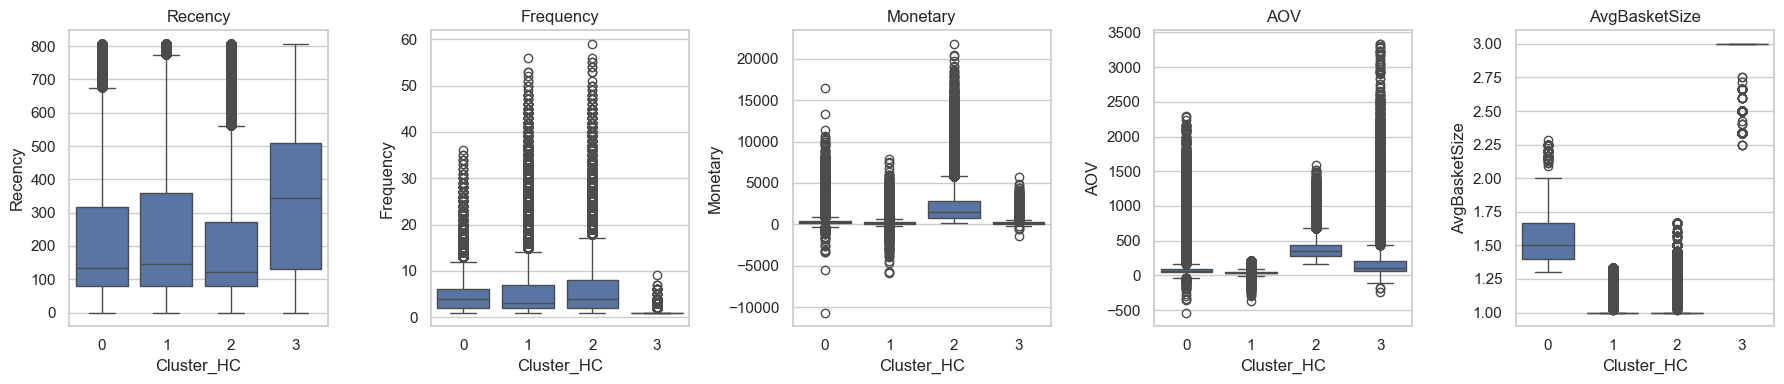

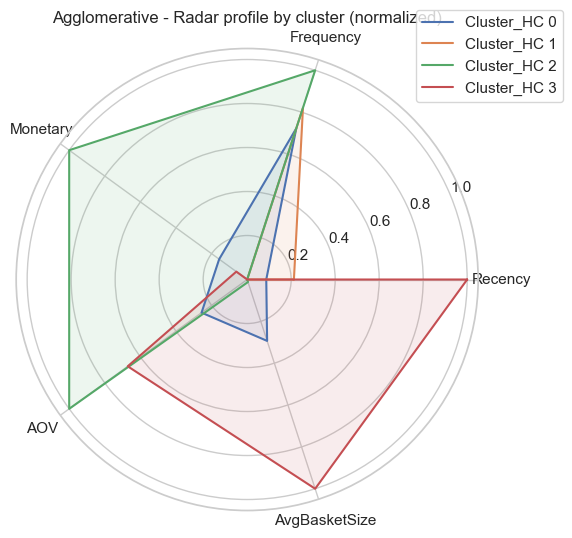

In [14]:
# Trực quan hoá hồ sơ cụm Agglomerative bằng boxplot & radar
plot_cols_hc = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']
plot_cols_hc += [c for c in ['CategoryEntropy','CategoryCount','PurchaseIntensity'] if c in rfm.columns]

n_hc = len(plot_cols_hc)
cols_hc = 5
rows_hc = math.ceil(n_hc / cols_hc)
fig, axes = plt.subplots(rows_hc, cols_hc, figsize=(18, 4*rows_hc))
axes = np.atleast_1d(axes).ravel()
for ax, col in zip(axes, plot_cols_hc):
    sns.boxplot(data=rfm, x='Cluster_HC', y=col, ax=ax)
    ax.set_title(col)
for ax in axes[n_hc:]:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Radar plot
feat_for_radar_hc = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']
feat_for_radar_hc += [c for c in ['CategoryEntropy','CategoryCount','PurchaseIntensity'] if c in rfm.columns]
radar_hc = rfm.groupby('Cluster_HC')[feat_for_radar_hc].mean()
radar_norm_hc = (radar_hc - radar_hc.min()) / (radar_hc.max() - radar_hc.min() + 1e-9)

angles = np.linspace(0, 2*np.pi, len(feat_for_radar_hc), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
for cl in radar_norm_hc.index:
    vals = radar_norm_hc.loc[cl].values
    vals = np.concatenate([vals, [vals[0]]])
    ax.plot(angles, vals, label=f'Cluster_HC {cl}')
    ax.fill(angles, vals, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feat_for_radar_hc)
ax.set_title('Agglomerative - Radar profile by cluster (normalized)')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


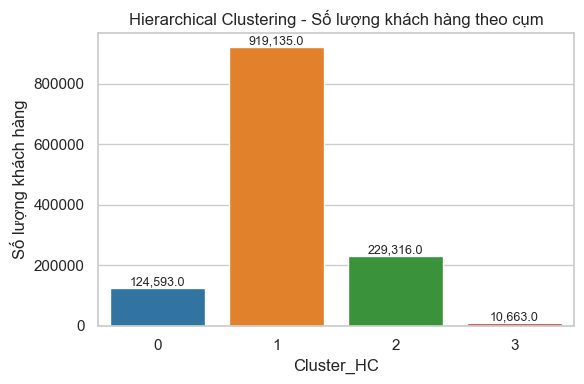

In [20]:
# Count Plot: số khách hàng trong từng cụm Agglomerative
plt.figure(figsize=(6,4))
ax = sns.countplot(data=rfm, x='Cluster_HC', palette='tab10')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, rotation=0)
ax.set_title('Hierarchical Clustering - Số lượng khách hàng theo cụm')
ax.set_xlabel('Cluster_HC')
ax.set_ylabel('Số lượng khách hàng')
plt.tight_layout()
plt.show()


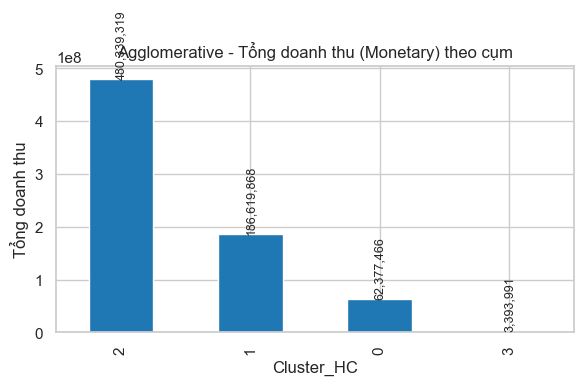

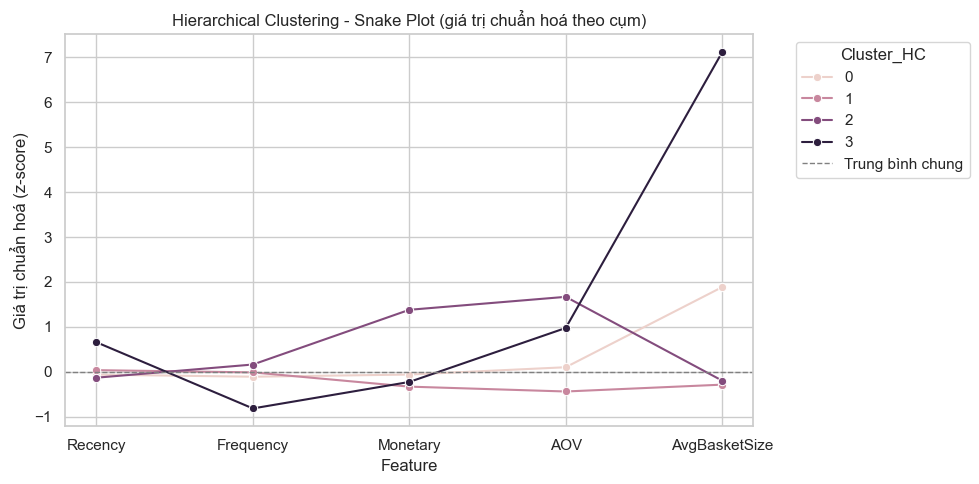

In [21]:
# Doanh thu & Snake Plot cho Agglomerative Clustering

# Tổng doanh thu theo cụm
monetary_sum_hc = rfm.groupby('Cluster_HC')['Monetary'].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
ax = monetary_sum_hc.plot(kind='bar', color='tab:blue')
for i, v in enumerate(monetary_sum_hc.values):
    ax.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9, rotation=90)
ax.set_title('Agglomerative - Tổng doanh thu (Monetary) theo cụm')
ax.set_xlabel('Cluster_HC')
ax.set_ylabel('Tổng doanh thu')
plt.tight_layout()
plt.show()

monetary_share_hc = (monetary_sum_hc / monetary_sum_hc.sum()).to_frame('RevenueShare_HC')
monetary_share_hc

# Snake Plot
from sklearn.preprocessing import StandardScaler

snake_features_hc = ['Recency','Frequency','Monetary','AOV','AvgBasketSize']

scaler_snake_hc = StandardScaler()
X_snake_hc = scaler_snake_hc.fit_transform(rfm[snake_features_hc])

snake_df_hc = pd.DataFrame(X_snake_hc, columns=snake_features_hc)
snake_df_hc['Cluster_HC'] = rfm['Cluster_HC'].values

snake_long_hc = snake_df_hc.groupby('Cluster_HC')[snake_features_hc].mean().reset_index().melt(
    id_vars='Cluster_HC', var_name='Feature', value_name='StandardizedValue'
)

plt.figure(figsize=(10,5))
ax = sns.lineplot(data=snake_long_hc, x='Feature', y='StandardizedValue', hue='Cluster_HC', marker='o')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, label='Trung bình chung')
ax.set_title('Hierarchical Clustering - Snake Plot (giá trị chuẩn hoá theo cụm)')
ax.set_ylabel('Giá trị chuẩn hoá (z-score)')
plt.legend(title='Cluster_HC', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [19]:
rfm.groupby('Cluster_HC')[['Recency','Frequency','Monetary','AOV','AvgBasketSize']].mean().round(2)


,Recency,Frequency,Monetary,AOV,AvgBasketSize
Cluster_HC,,,,,
0,204.95,4.49,500.65,129.39,1.58
1,224.23,4.93,203.04,42.56,1.03
2,191.63,5.72,2094.66,381.36,1.05
3,345.04,1.31,318.30,269.94,2.92
